# Data Analysis
The goal of this notebook is to discover patterns in the dataSet, that will help selecting relevant variables and doing efficient preprocessing on the data.

In [37]:
# standard 
import os
import datetime as dt
from math import *

# external
import numpy as np
import pandas as pd
from hijri_converter import Hijri, Gregorian
import ephem


# Stats
from statsmodels.tsa.stattools import adfuller
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

# dimension reduction
from sklearn.decomposition import PCA

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-bright')
palette = sns.color_palette("rocket_r")

### Loading data

In [2]:
df = pd.read_csv("./data/original_data/data.txt", sep = "     ",index_col = None)

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
df.head()

,COEF_MAREE UT: 0.0
2000-01-01 12:21:00,48
2000-01-02 00:53:00,50
2000-01-02 13:19:00,53
2000-01-03 01:45:00,56
2000-01-03 14:08:00,60


Above we have a serie of calculated tidal coefficients. The last are coefficients that tell us the amplitude of the tide forecast (difference in height between the consecutive high tides and low tides in any given area). They are calculated from a series of temporal data obtained from mareographs in previous years. This series of data could be adapted by the method of least squares using Foreman's algorithm (Foreman, M.G.G., 1977. Manual for Tidal Heights Analysis and Prediction).
- Objectif of this project: 
    - Forcasting new future tidal coefficients using a long serie of calculated coefficients.

### Data info
Cheking data type and NaN values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15292 entries, 2000-01-01 12:21:00 to 2021-08-31 22:24:00
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COEF_MAREE   UT: 0.0  15292 non-null  int64
dtypes: int64(1)
memory usage: 238.9+ KB


- There are no NaN values in the dataSet

In [5]:
df.describe()

,COEF_MAREE UT: 0.0
count,15292.000000
mean,69.799045
std,20.370253
min,22.000000
25%,53.000000
50%,71.000000
75%,85.000000
max,118.000000


- Normal tidal coefficients are between  20 and 120. We don't see any strange values(values that lie outside this range) in the dataSet.

In [6]:
df.reset_index(inplace = True)
df.rename(columns = {'index':'dateTime', 'COEF_MAREE   UT: 0.0':'coef'}, inplace = True)
df.head()

,dateTime,coef
0,2000-01-01 12:21:00,48
1,2000-01-02 00:53:00,50
2,2000-01-02 13:19:00,53
3,2000-01-03 01:45:00,56
4,2000-01-03 14:08:00,60


### Adding Date-Time related features
Date, Time-related features help understanding patterns in the dataSet.
- Since tidal phenomena is due to both sun's attraction and moon's attraction, it would be intersting to explore patterns in the dataSet using hirji calendar which is basically calculated using the moon phases.

In [7]:
df['dateTime'] = pd.to_datetime(df['dateTime'])
df['date'] = df['dateTime'].dt.date.values
df['time'] = df["dateTime"].dt.time.values
df['day'] = df['dateTime'].dt.day.values
df['month'] = df['dateTime'].dt.month.values
df['year'] = df['dateTime'].dt.year.values
df['hijri_day'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)
df['hijri_month'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_year'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().year)
df['quarter'] = df['dateTime'].dt.quarter.values
df['hour'] = df['dateTime'].dt.hour.values


In [8]:
df.head()

,dateTime,coef,date,time,day,month,year,hijri_day,hijri_month,hijri_year,quarter,hour
0,2000-01-01 12:21:00,48,2000-01-01,12:21:00,1,1,2000,24,9,1420,1,12
1,2000-01-02 00:53:00,50,2000-01-02,00:53:00,2,1,2000,25,9,1420,1,0
2,2000-01-02 13:19:00,53,2000-01-02,13:19:00,2,1,2000,25,9,1420,1,13
3,2000-01-03 01:45:00,56,2000-01-03,01:45:00,3,1,2000,26,9,1420,1,1
4,2000-01-03 14:08:00,60,2000-01-03,14:08:00,3,1,2000,26,9,1420,1,14


In [9]:
df.hijri_year.max()

1443

#### 

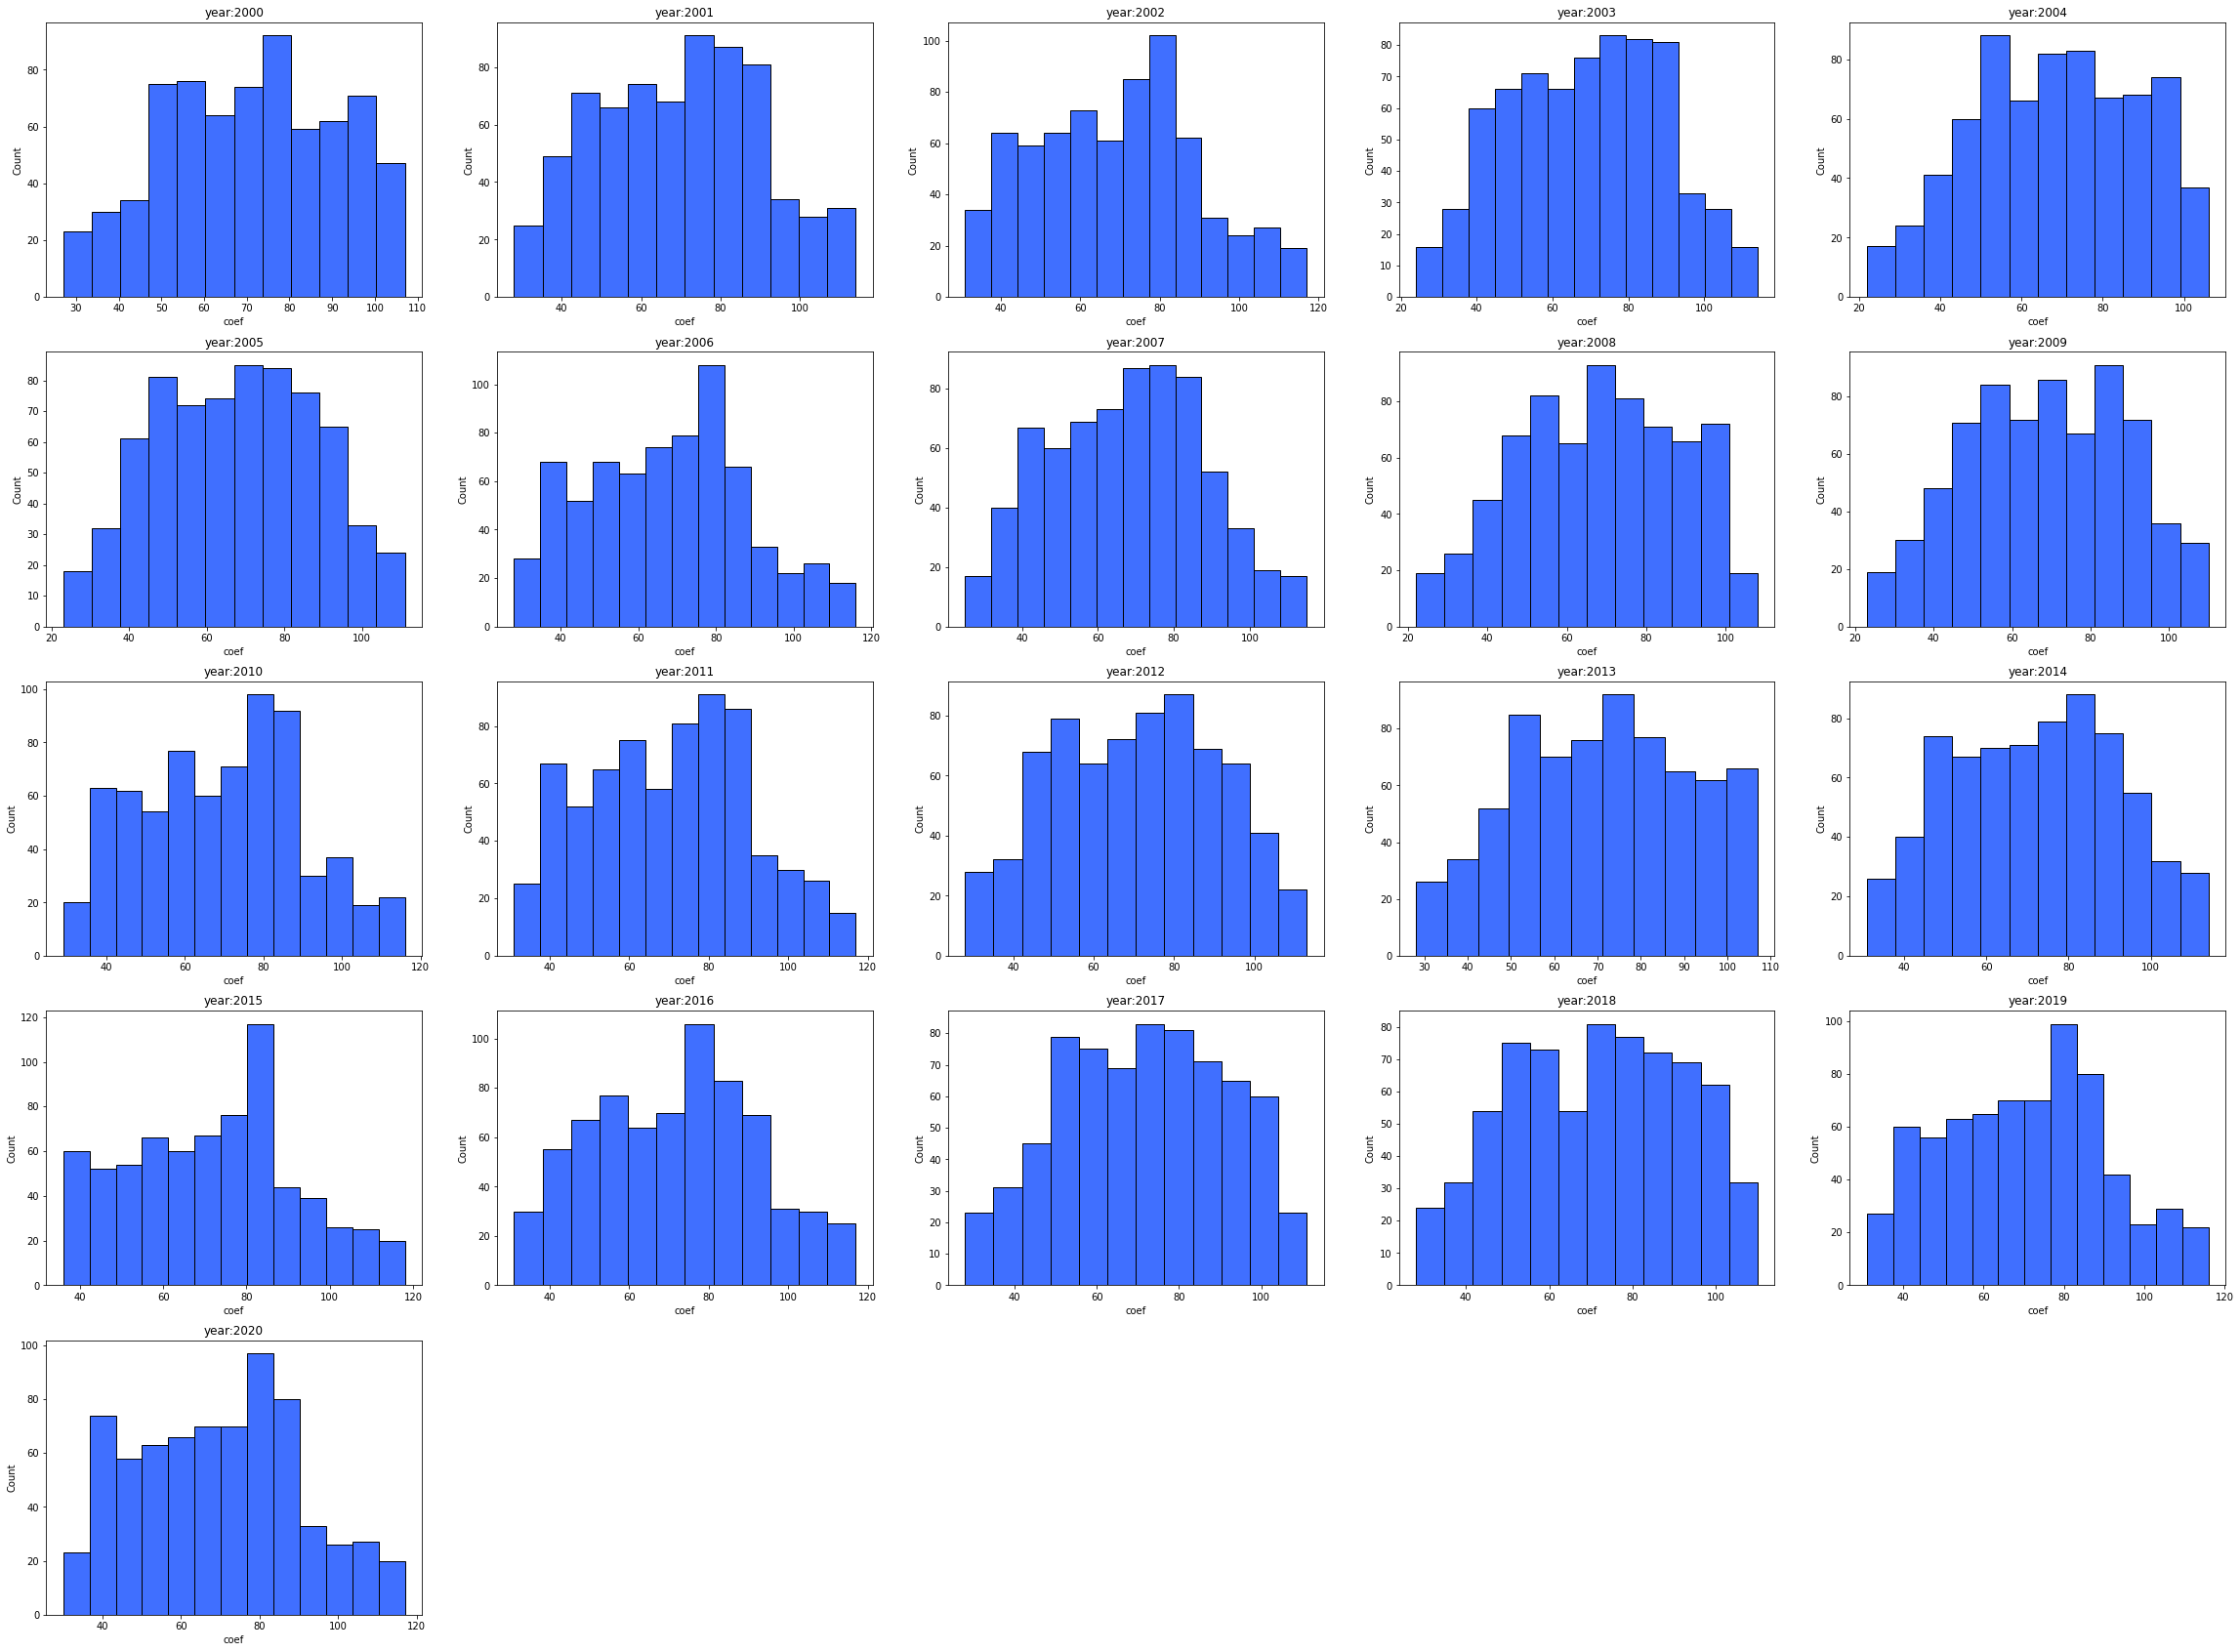

In [10]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(40,30))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    sns.histplot(data["coef"])
    plt.title("year:"+ str(years[i]))

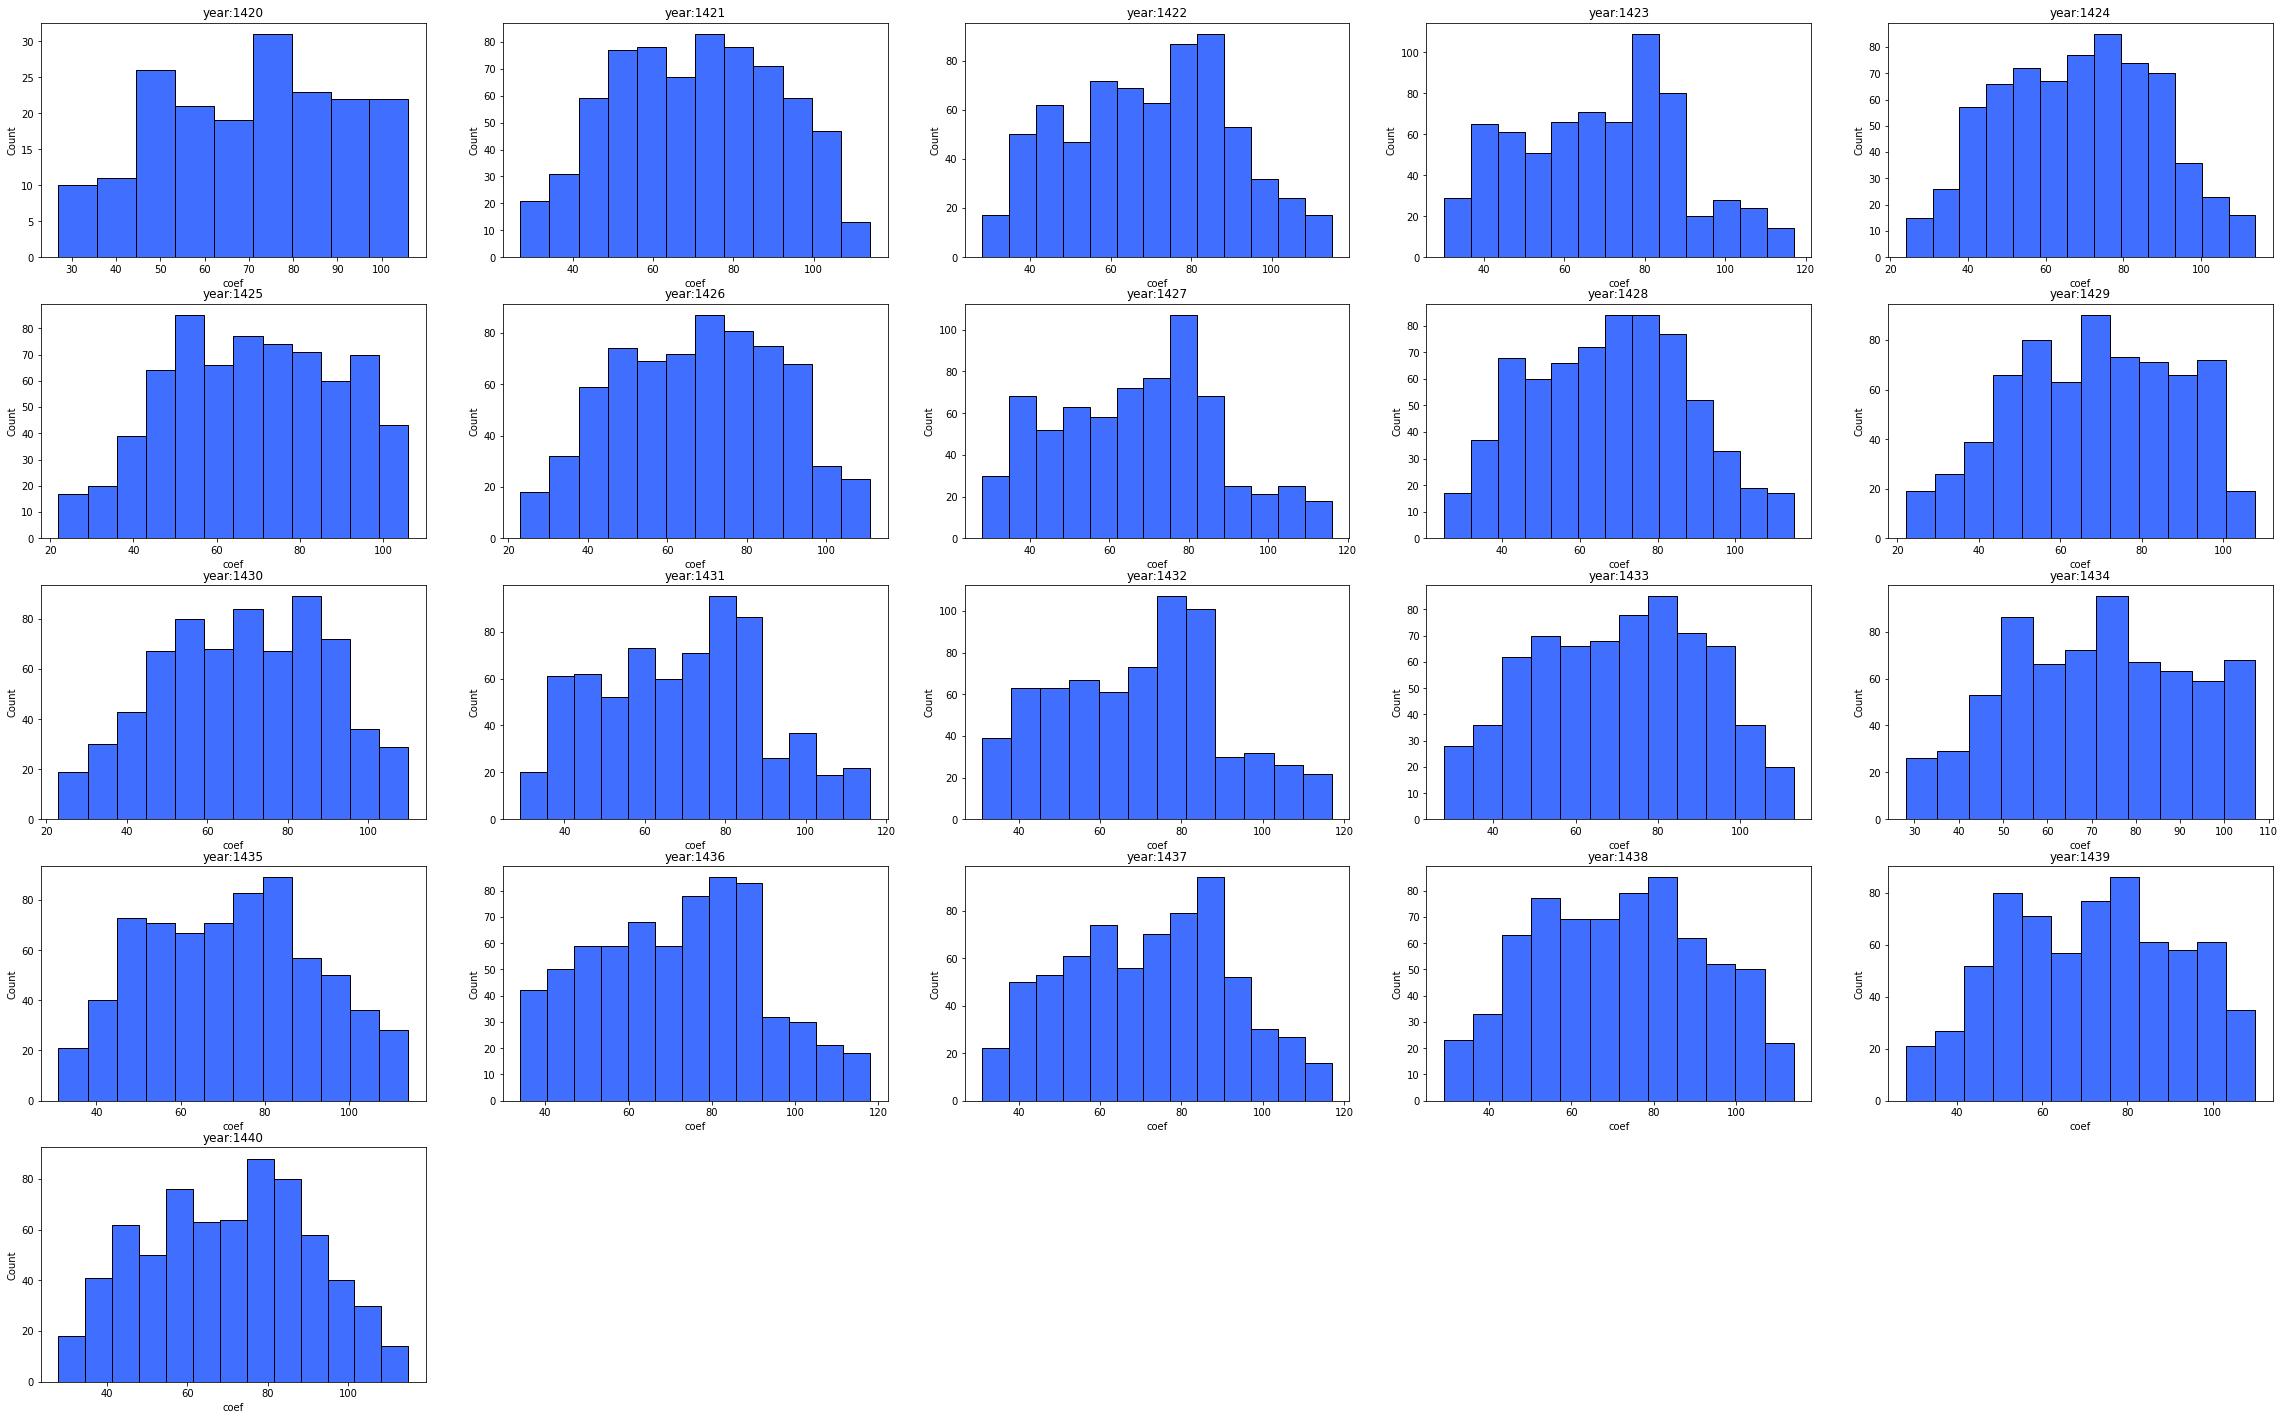

In [11]:
hijri_years = np.arange(df.hijri_year.min(),df.hijri_year.max(), 1)
plt.figure(figsize=(40,25))
for i in range(21):
    data = df[df["hijri_year"] == hijri_years[i]]
    plt.subplot(5,5,i+1)
    sns.histplot(data["coef"])
    plt.title("year:"+ str(hijri_years[i]))

### How does the distribution of tidal coefficients changes over months?

<Figure size 2880x1440 with 0 Axes>

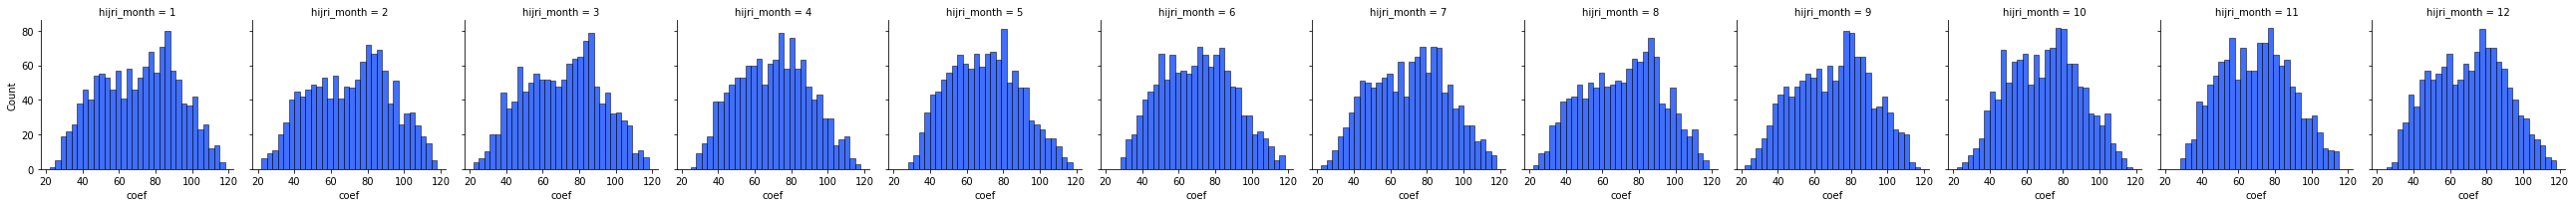

In [12]:
plt.figure(figsize=(40,20))
sns.displot(
    df, x="coef", col="hijri_month",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True)
)

<Figure size 2880x1440 with 0 Axes>

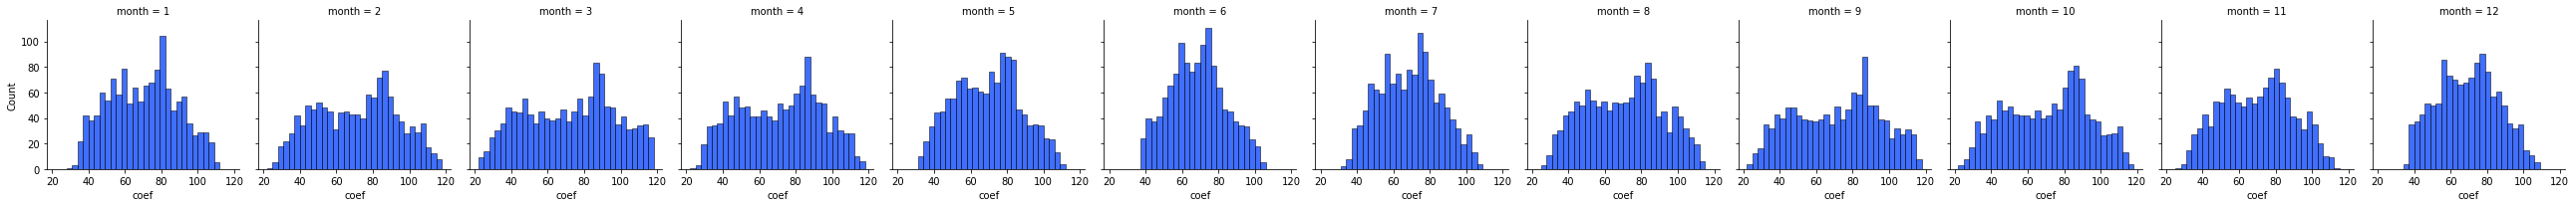

In [13]:
plt.figure(figsize=(40,20))
sns.displot(
    df, x="coef", col="month",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True)
)

- ALL hijri months have roughly the same distribution of tidal coeffcients. (quite similar shapes and ranges)
- In contrast Gregorian months have quite different distributions. (differents shapes and ranges)

### Is there any relation between the coefficients of a the months of two given years?

In [14]:
df[df["hijri_year"]==1440][df["hijri_month"]==6]["coef"].shape

C:\Users\Otmane\AppData\Local\Temp/ipykernel_14472/858922122.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["hijri_year"]==1440][df["hijri_month"]==6]["coef"].shape


(58,)

In [15]:
df[df["hijri_year"]==1441][df["hijri_month"]==6]["coef"].shape

C:\Users\Otmane\AppData\Local\Temp/ipykernel_14472/4087242413.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["hijri_year"]==1441][df["hijri_month"]==6]["coef"].shape


(58,)

C:\Users\Otmane\AppData\Local\Temp/ipykernel_14472/804550913.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["hijri_year"]==1432][df["hijri_month"]==5]["coef"], df[df["hijri_year"]==1442][df["hijri_month"]==5]["coef"]);


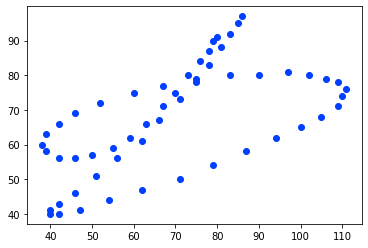

In [16]:
plt.scatter(df[df["hijri_year"]==1432][df["hijri_month"]==5]["coef"], df[df["hijri_year"]==1442][df["hijri_month"]==5]["coef"]);

C:\Users\Otmane\AppData\Local\Temp/ipykernel_14472/310169037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["year"]==2002][df["month"]==5]["coef"], df[df["year"]==2003][df["month"]==5]["coef"]);


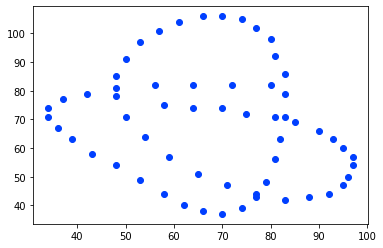

In [17]:
plt.scatter(df[df["year"]==2002][df["month"]==5]["coef"], df[df["year"]==2003][df["month"]==5]["coef"]);

- There is no clear relationship between 2 months of a given 2 years.(Using both hirji and gregorian calendars)

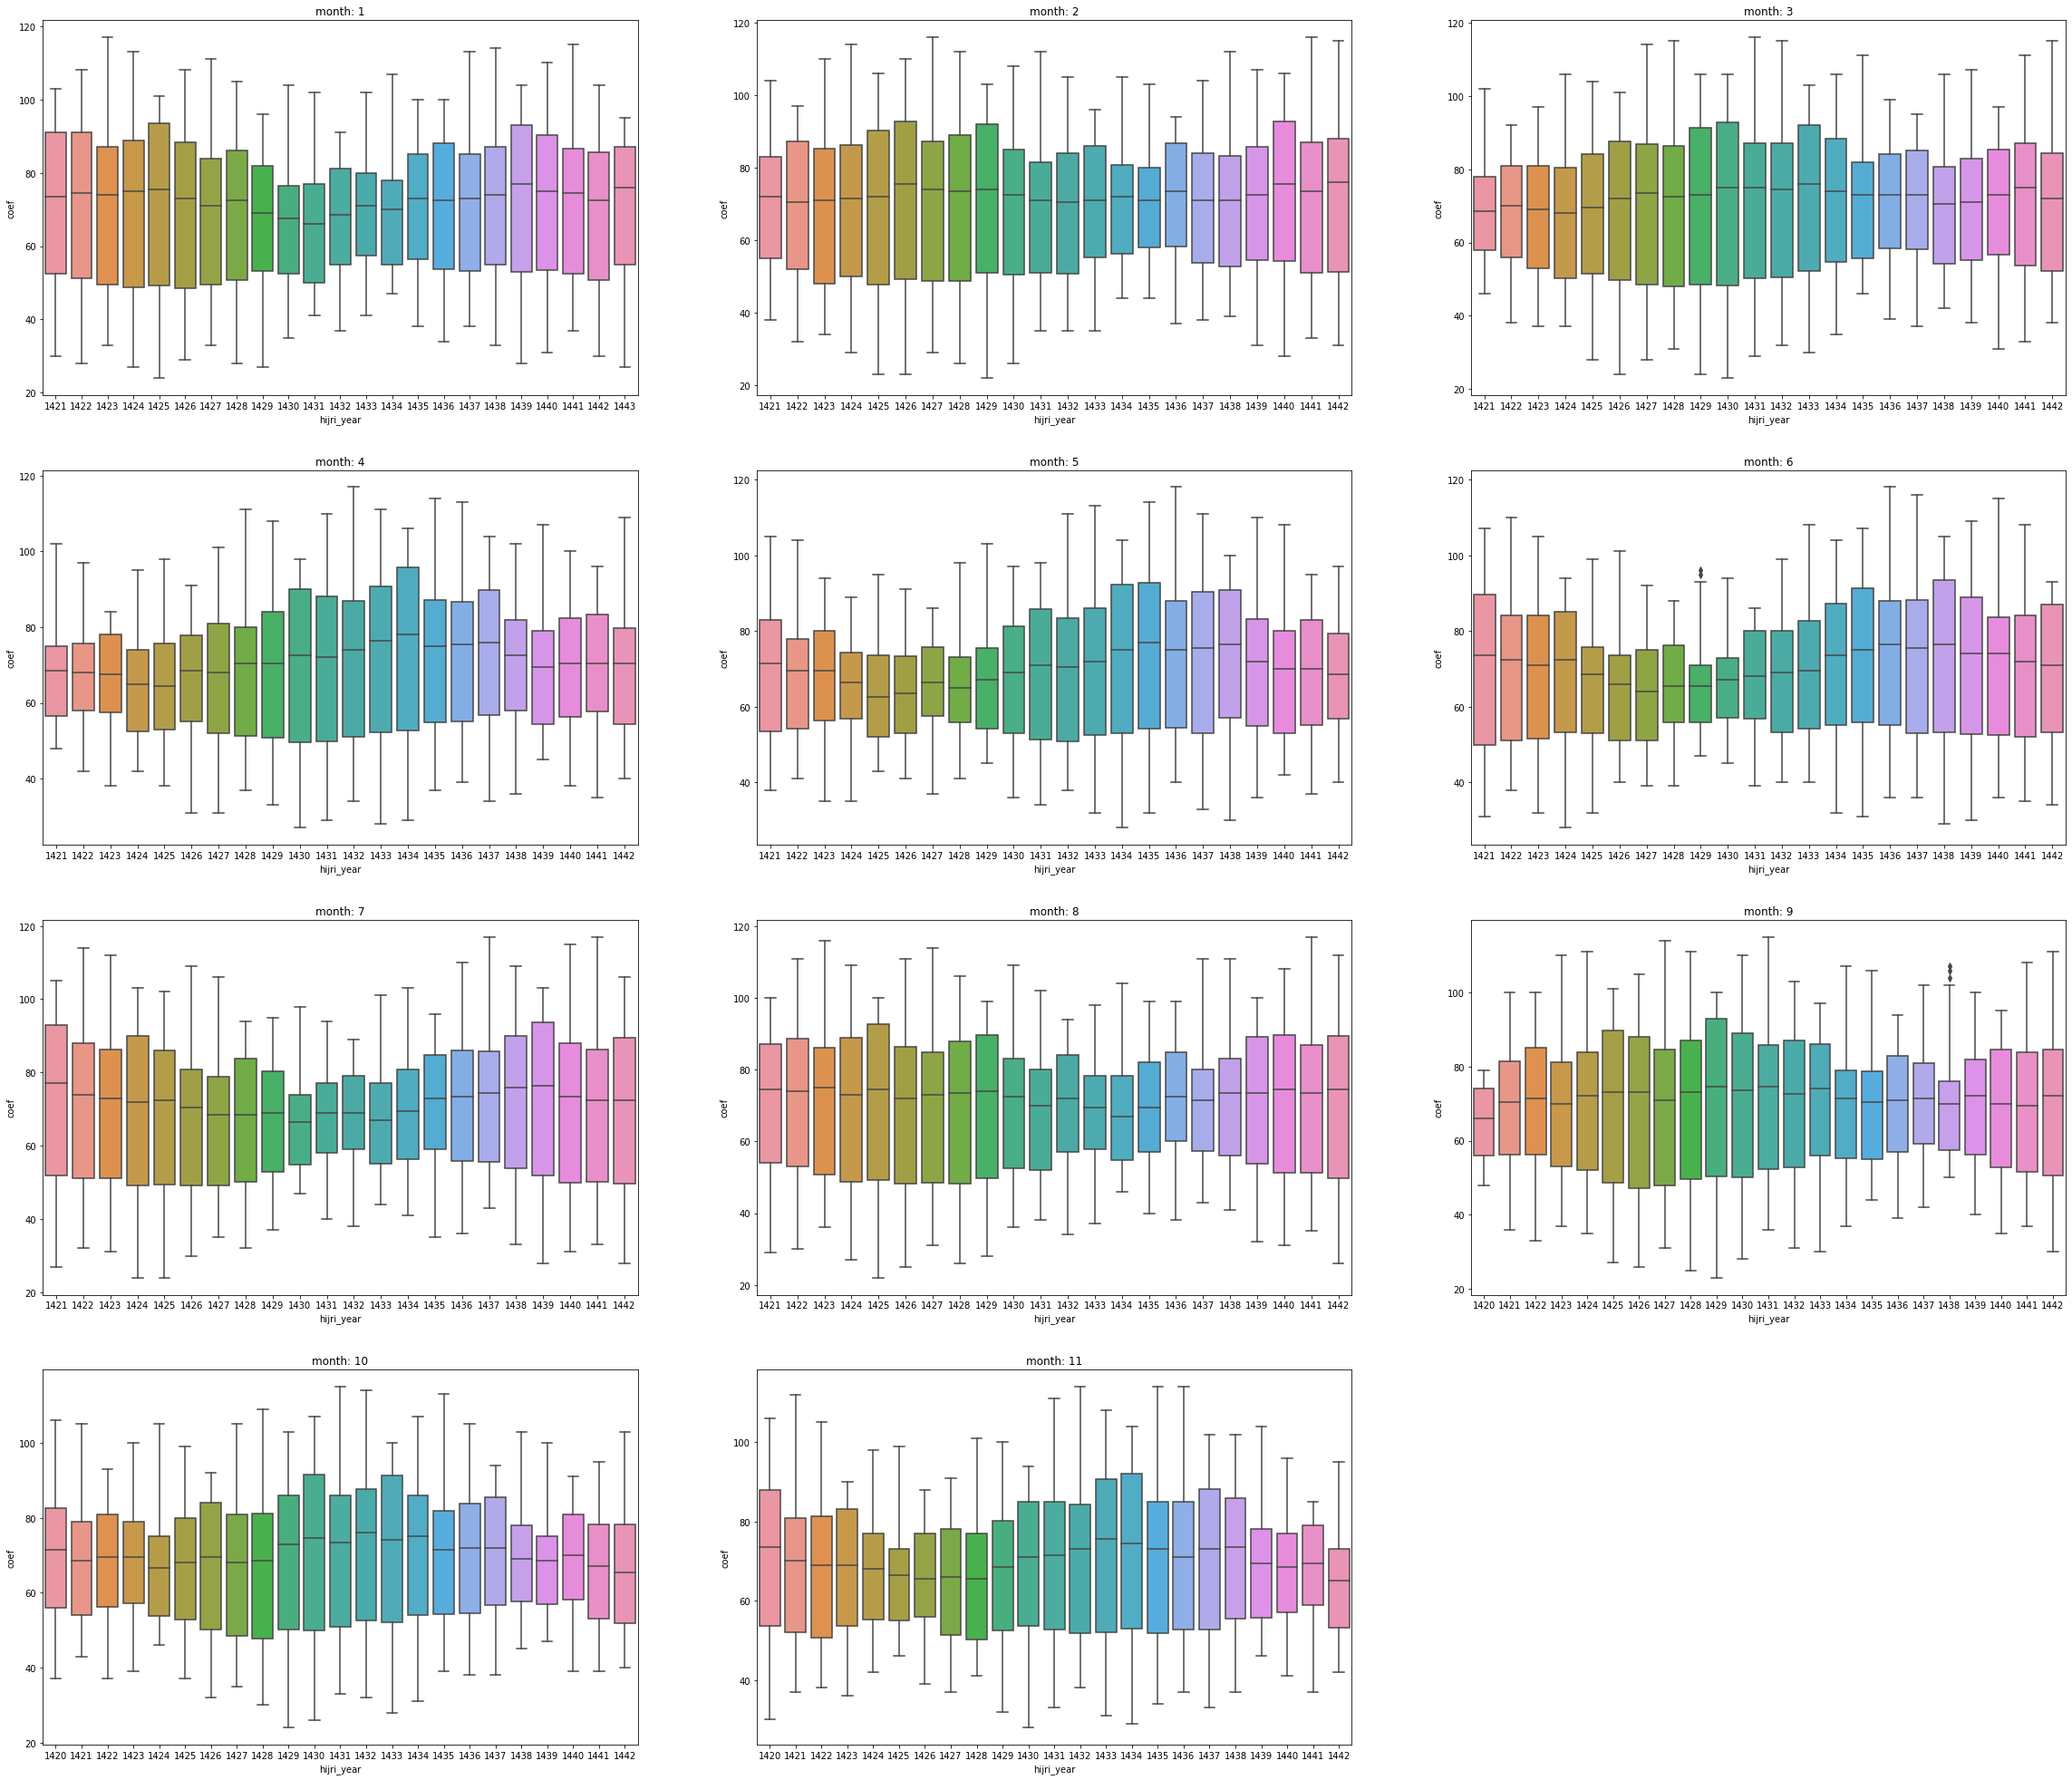

In [18]:
hijri_months = np.arange(df.hijri_month.min(),df.hijri_month.max(), 1)
plt.figure(figsize=(40,35))
for i in range(11):
    data = df[df["hijri_month"] == hijri_months[i]]
    plt.subplot(4,3,i+1)
    sns.boxplot(x="hijri_year", y="coef", data=data)
    plt.title("month: "+ str(hijri_months[i]))

- The distribution of the coefficients for a given month changes from year to year. (no clear pattern)
- We could notice some high values for :
    - month 6 : year 1429
    - month 9 : year 1438


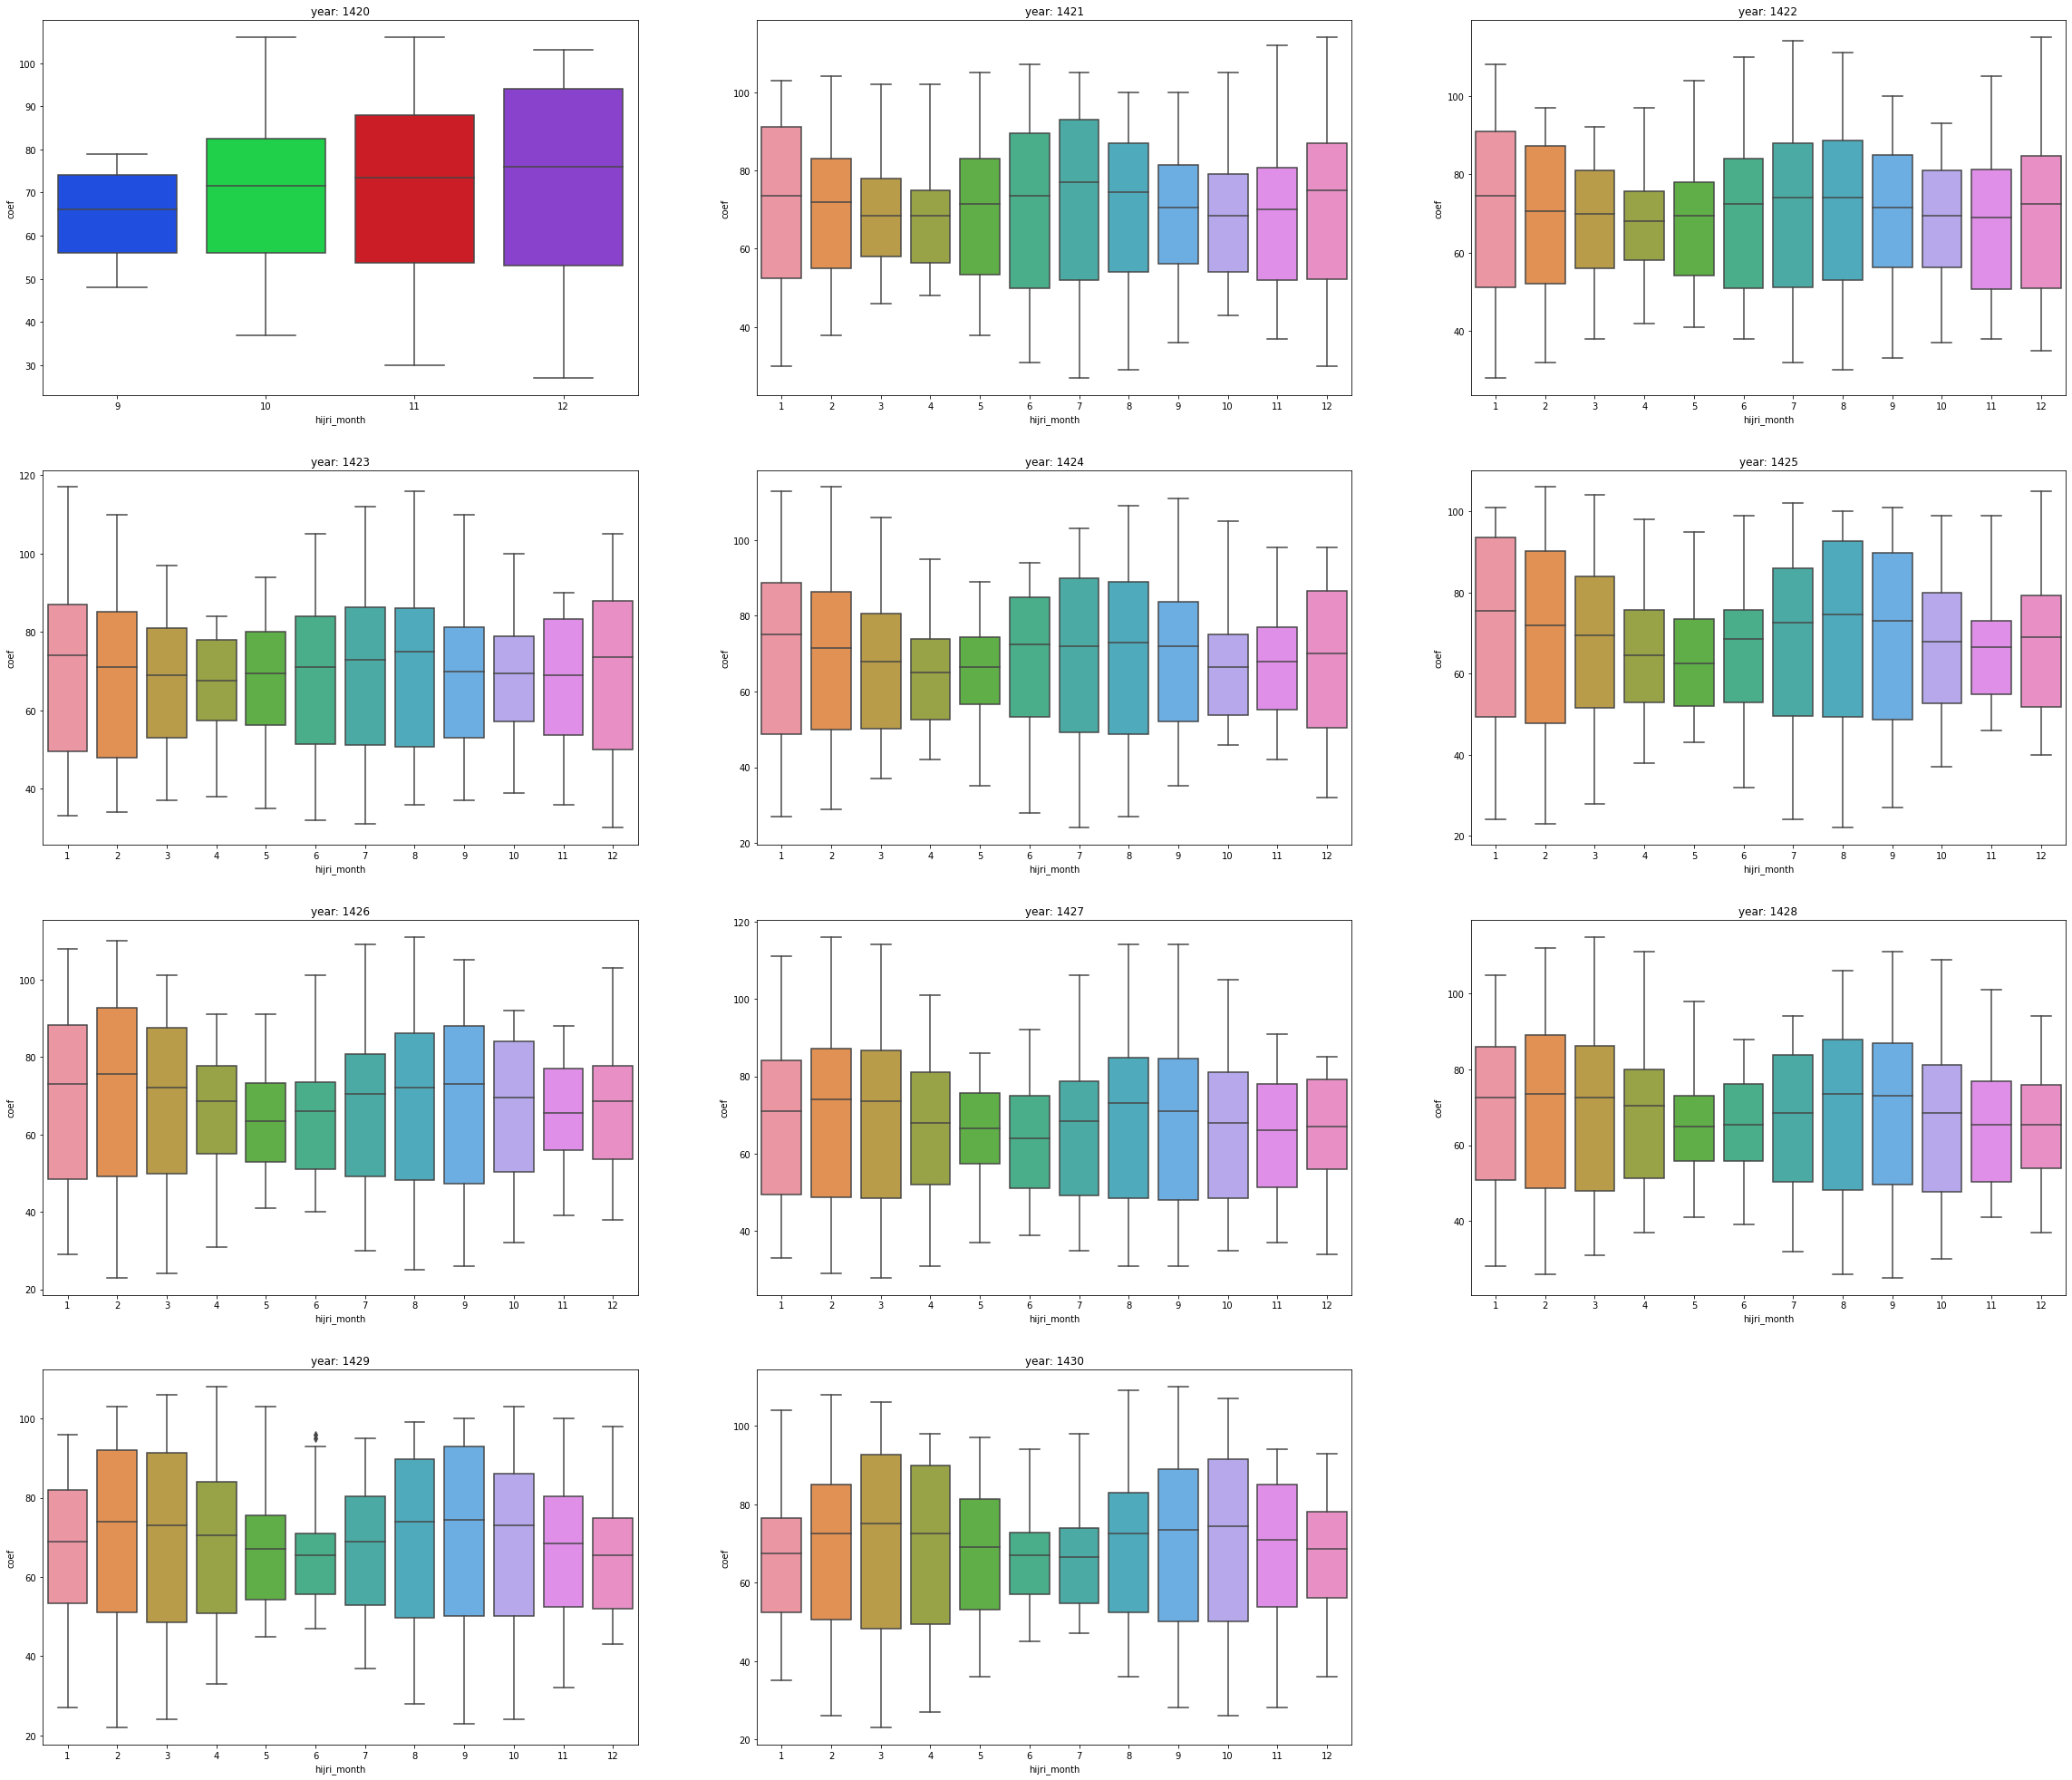

In [19]:
hijri_years = np.arange(df.hijri_year.min(),df.hijri_year.max(), 1)
plt.figure(figsize=(40,35))
for i in range(11):
    data = df[df["hijri_year"] == hijri_years[i]]
    plt.subplot(4,3,i+1)
    sns.boxplot(x="hijri_month", y="coef", data=data)
    plt.title("year: "+ str(hijri_years[i]))

- We could notice some remarquable patterns:
    - Periodic change in the coefficients range over the 21 years 
    - Each year represent one periode of variation, for example in the plot representing the year 1421, we could notice 1/4*T (where T=1 year is the periode) from month 1 to month 3 and 1/2*T from month 
    4 to month 9 and last 1/4*T from month 10 to month 12.

Conclusion: Strong seasonal effect.

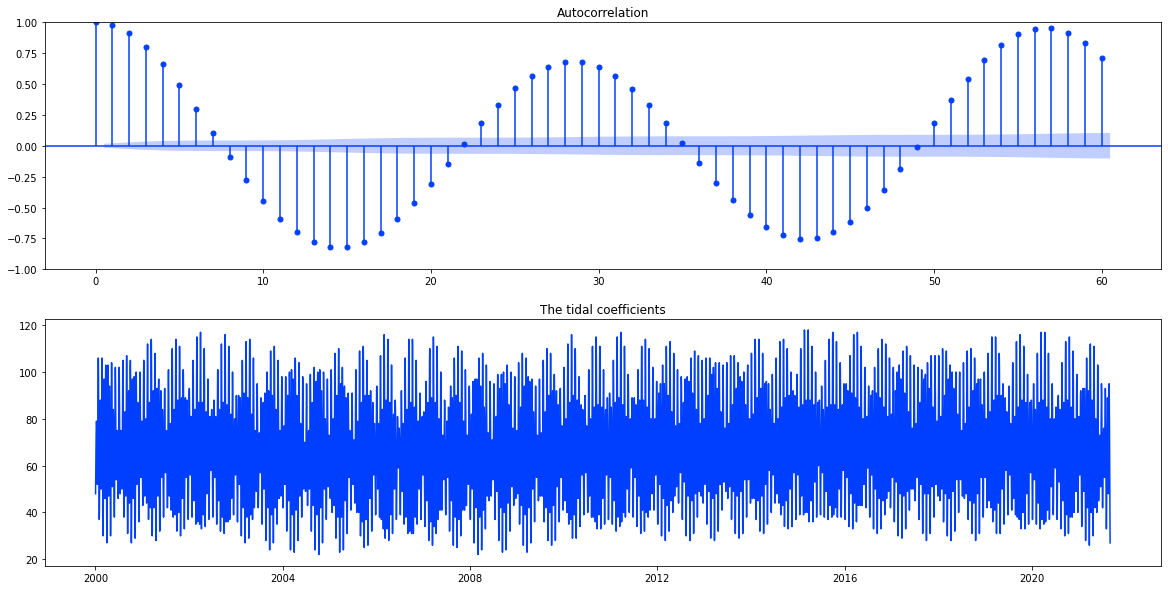

In [20]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
plot_acf(df.coef, lags =60, ax=ax[0])
plt.plot(df.dateTime, df.coef)
plt.title("The tidal coefficients");

- We see cycles of strong negative and positive correlation.

- Sine waves like those are a strong sign of seasonality in the dataset.

- The ACF above fails to weed out the redundant correlations.
- The PACF, on the other hand, reveals which
    correlations are “true” informative correlations for specific lags rather than redun‐
    dancies.

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


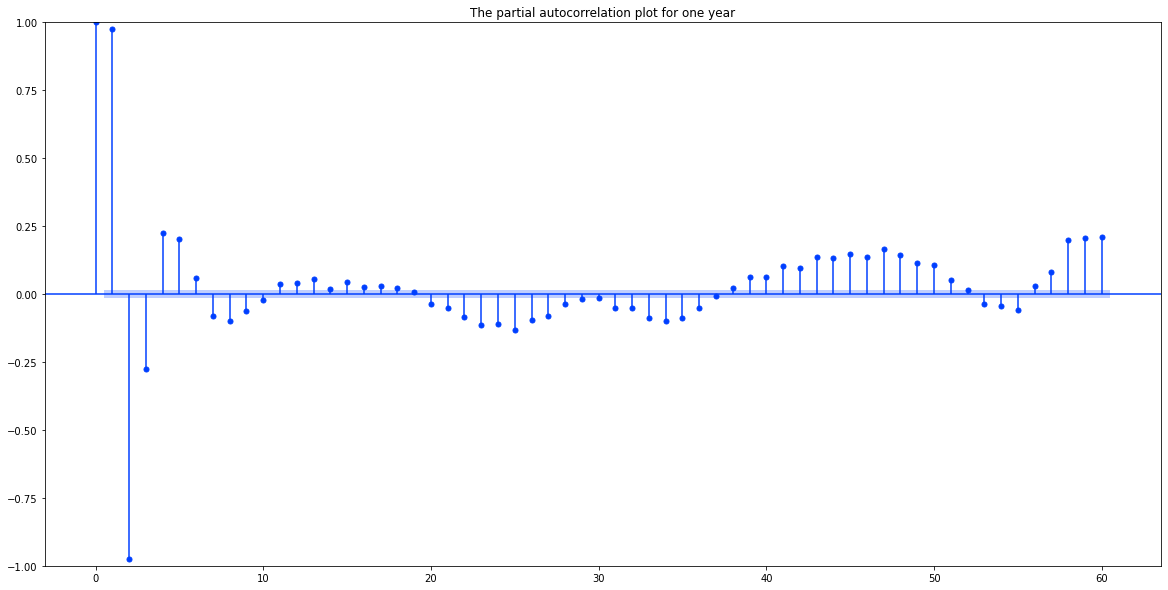

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df.coef, lags =60, ax = ax)
plt.title("The partial autocorrelation plot for one year");

### Correlation with some of moon and sun related features?

Phases and tides:
- During the full moon and new moon phases, the Moon and the Sun are aligned and their effects combined, producing the spring tides.
- During waxing and waning moons, on the contrary, the effects are detracted, thereby obtaining tides of less amplitude (lower tidal coefficient), called neap tides.

In [22]:
# Moon related features
def getMoonPhase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.moon_phase

def getMoonDistance(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.earth_distance

def getMoonSunDistance(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.sun_distance

def getMoonLibrationLatitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.libration_lat

def getMoonLibrationLongitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.libration_long

def getMoonSubSolarLatitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.subsolar_lat

def getMoonElongation(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.elong

# Sun related features
def getSunEarthDistance(date):
    sun = ephem.Sun()
    sun.compute(date)
    return sun.earth_distance

In [23]:
df["moon_phase"] = df['date'].apply(lambda x :getMoonPhase(x))
df["earth_moon_distance"] = df['date'].apply(lambda x: getMoonDistance(x))
df["sun_moon_distance"] = df['date'].apply(lambda x: getMoonSunDistance(x))
df["libration_lat"] = df['date'].apply(lambda x: getMoonLibrationLatitude(x))
df["libration_long"] = df['date'].apply(lambda x: getMoonLibrationLongitude(x))
df["subsolar_latitude"] = df['date'].apply(lambda x: getMoonSubSolarLatitude(x))
df["elongation"] = df['date'].apply(lambda x: getMoonElongation(x))
df["earth_sun_distance"] = df['date'].apply(lambda x: getSunEarthDistance(x))

In [24]:
df.head()

,dateTime,coef,date,time,day,month,year,hijri_day,hijri_month,hijri_year,quarter,hour,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance
0,2000-01-01 12:21:00,48,2000-01-01,12:21:00,1,1,2000,24,9,1420,1,12,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332
1,2000-01-02 00:53:00,50,2000-01-02,00:53:00,2,1,2000,25,9,1420,1,0,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
2,2000-01-02 13:19:00,53,2000-01-02,13:19:00,2,1,2000,25,9,1420,1,13,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
3,2000-01-03 01:45:00,56,2000-01-03,01:45:00,3,1,2000,26,9,1420,1,1,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322
4,2000-01-03 14:08:00,60,2000-01-03,14:08:00,3,1,2000,26,9,1420,1,14,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322


In [25]:
sub_df = df.loc[:,["coef", "moon_phase", "earth_moon_distance", "sun_moon_distance", "libration_lat", "libration_long", "subsolar_latitude", "elongation", "earth_sun_distance"]]

In [26]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15292 entries, 0 to 15291
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 15292 non-null  int64  
 1   moon_phase           15292 non-null  float64
 2   earth_moon_distance  15292 non-null  float64
 3   sun_moon_distance    15292 non-null  float64
 4   libration_lat        15292 non-null  float64
 5   libration_long       15292 non-null  float64
 6   subsolar_latitude    15292 non-null  float64
 7   elongation           15292 non-null  float64
 8   earth_sun_distance   15292 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.1 MB


- No missing data

In [27]:
sub_df.describe()

,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance
count,15292.000000,15292.000000,15292.000000,15292.000000,15292.000000,15292.000000,15292.000000,15292.000000,15292.000000
mean,69.799045,0.500457,0.002574,1.000234,0.000984,-0.000184,-0.000149,-0.013864,1.000235
std,20.370253,0.355343,0.000102,0.011984,0.082540,0.079381,0.019013,1.813280,0.011833
min,22.000000,0.000005,0.002384,0.980627,-0.119412,-0.140659,-0.027157,-3.134393,0.983244
25%,53.000000,0.139799,0.002481,0.988498,-0.081473,-0.075704,-0.019105,-1.614971,0.988383
50%,71.000000,0.502908,0.002579,1.000417,0.001318,-0.000177,-0.000312,-0.024840,1.000471
75%,85.000000,0.858834,0.002674,1.011933,0.083187,0.074850,0.018843,1.516194,1.012085
max,118.000000,0.999994,0.002719,1.019356,0.120131,0.140671,0.027159,3.129121,1.016755


- The added features have quite different ranges, we may consider some scaling.

### Correlations?

<AxesSubplot:>

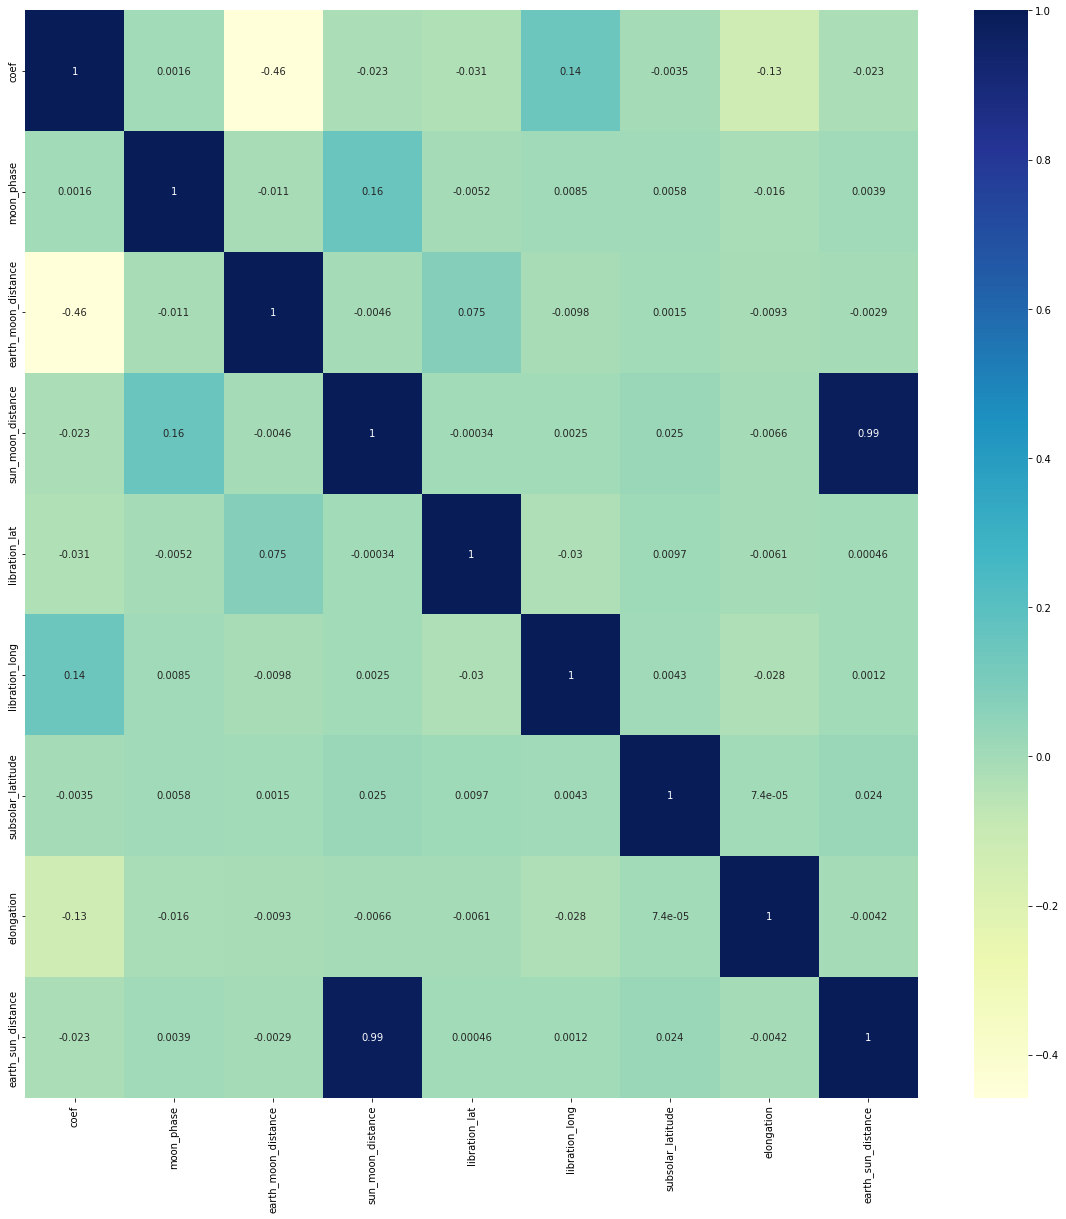

In [28]:
plt.figure(figsize=(20,20))
corr =sub_df.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=sub_df.columns, yticklabels=sub_df.columns,annot=True)

- Only weak linear correlation with the target variable!
- The earth_sun_distance and the sun_moon_distance are highly correlated --> we could consider ometting the last.


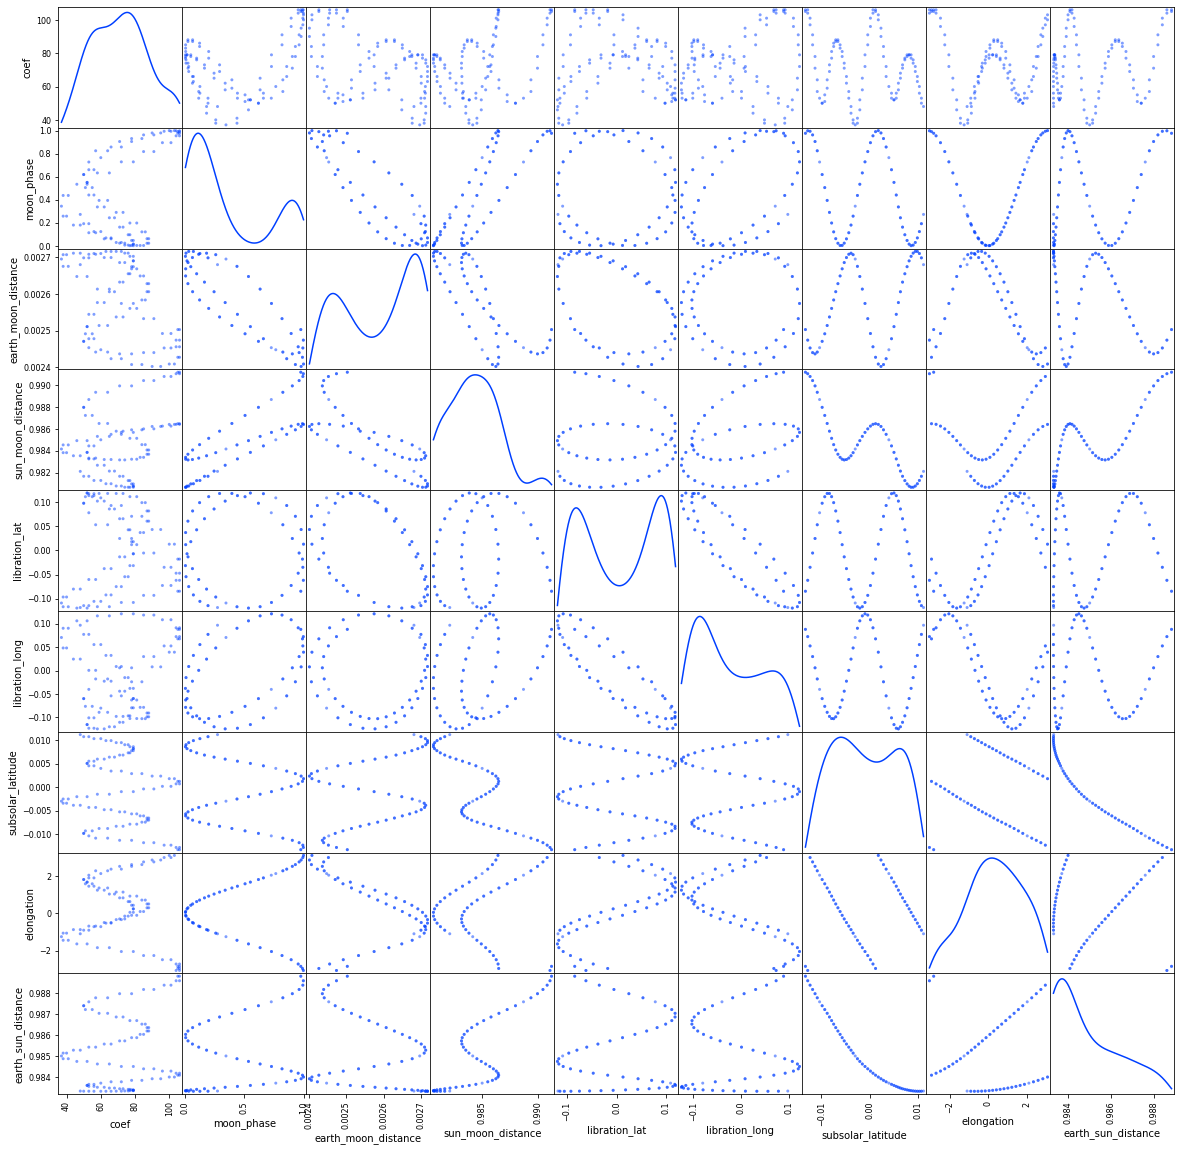

In [29]:
scatter_matrix(sub_df.iloc[:100,:], figsize=(20, 20), diagonal="kde"); # Approximatly one year!

- All the  features seems to be correlated with the target variable.
- The earth_sun_distance and the sun_moon_distance seems to have different effects on the target variable. We could consider keeping both of them despite the fact of being highly correlated.

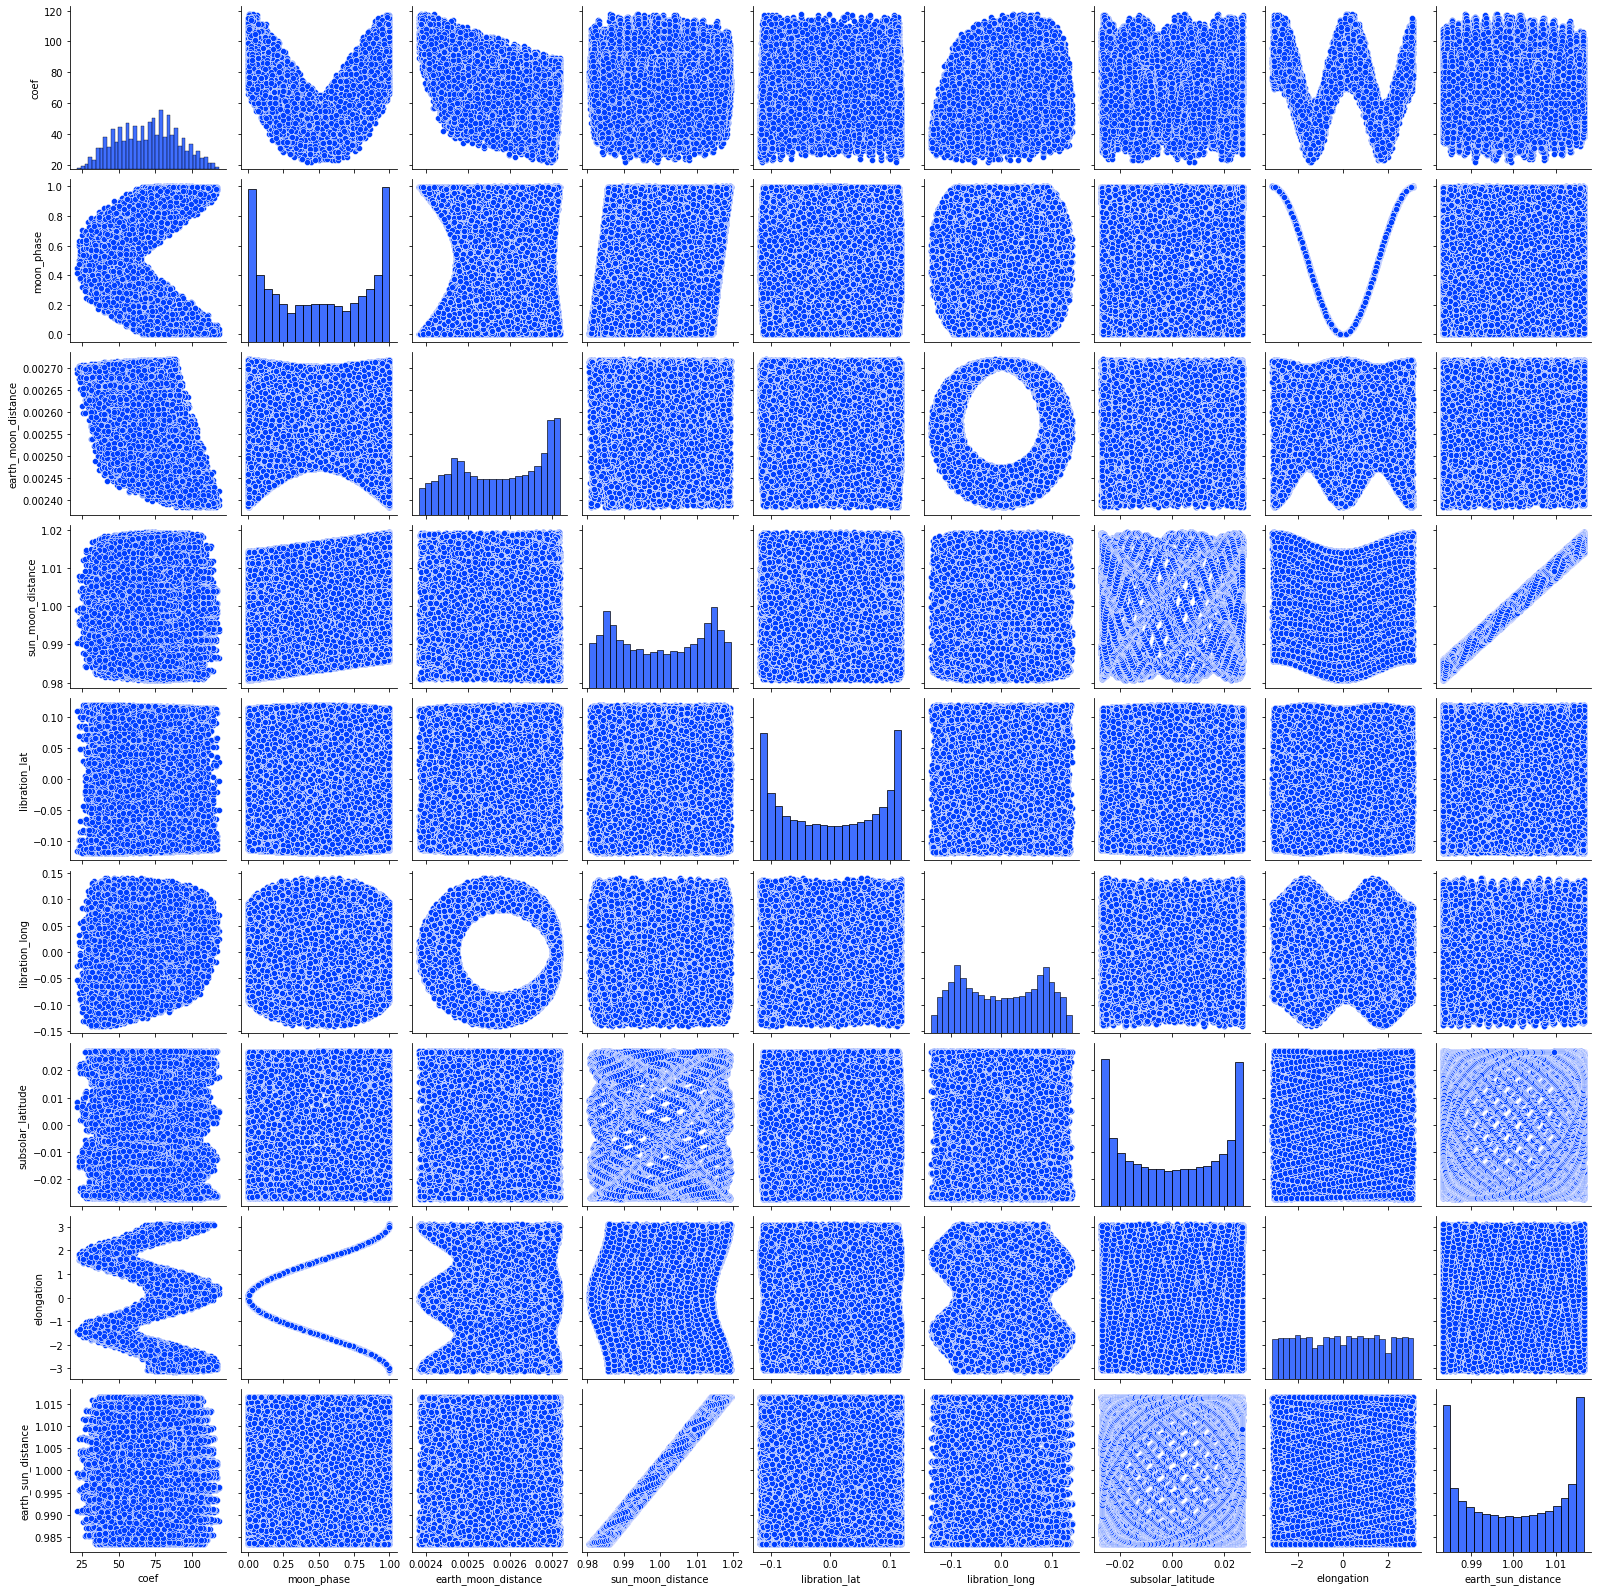

In [30]:
sns.pairplot(sub_df)

### Analysis in reduced dimension

Reducing dimensionality help better understand which are the useful
features, and which are grouped together.

In [31]:
sub_df

,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance
0,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332
1,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
2,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
3,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322
4,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322
...,...,...,...,...,...,...,...,...,...
15287,46,0.622453,0.002696,1.010618,0.029032,0.027921,0.026978,-1.817155,1.009957
15288,40,0.529312,0.002701,1.009891,0.005509,0.003709,0.026927,-1.627771,1.009733
15289,34,0.529312,0.002701,1.009891,0.005509,0.003709,0.026927,-1.627771,1.009733
15290,30,0.435239,0.002698,1.009155,-0.018214,-0.020732,0.026867,-1.438557,1.009507


In [32]:
df_features = sub_df.iloc[:,1:]

In [33]:
SC = StandardScaler()
X = SC.fit_transform(df_features)

In [34]:
pca = PCA()
X_pca = pca.fit_transform(X)
pd.DataFrame(pca.components_.T, index=list(df_features.columns))

,0,1,2,3,4,5,6,7
moon_phase,-0.113131,0.146446,0.353646,0.085439,-0.869237,0.251824,-0.053036,-0.107654
earth_moon_distance,0.006423,-0.639355,0.221548,-0.102963,0.100231,0.306805,-0.653700,0.000005
sun_moon_distance,-0.706397,-0.003127,-0.009652,-0.023698,-0.000603,0.006243,-0.000578,0.707318
libration_lat,0.000709,-0.678670,0.126266,0.015943,-0.089492,0.054095,0.715734,-0.000003
libration_long,-0.004019,0.321839,0.535447,0.003014,0.436098,0.609508,0.219110,-0.000012
subsolar_latitude,-0.035384,-0.068784,0.124722,0.971468,0.108325,-0.124931,-0.085842,-0.000266
elongation,0.009414,-0.014258,-0.709514,0.190044,-0.081821,0.671813,0.046401,0.000062
earth_sun_distance,-0.697715,-0.025714,-0.064384,-0.037512,0.133275,-0.032384,0.007612,-0.698650


Text(0.5, 1.0, 'Features effect on each components')

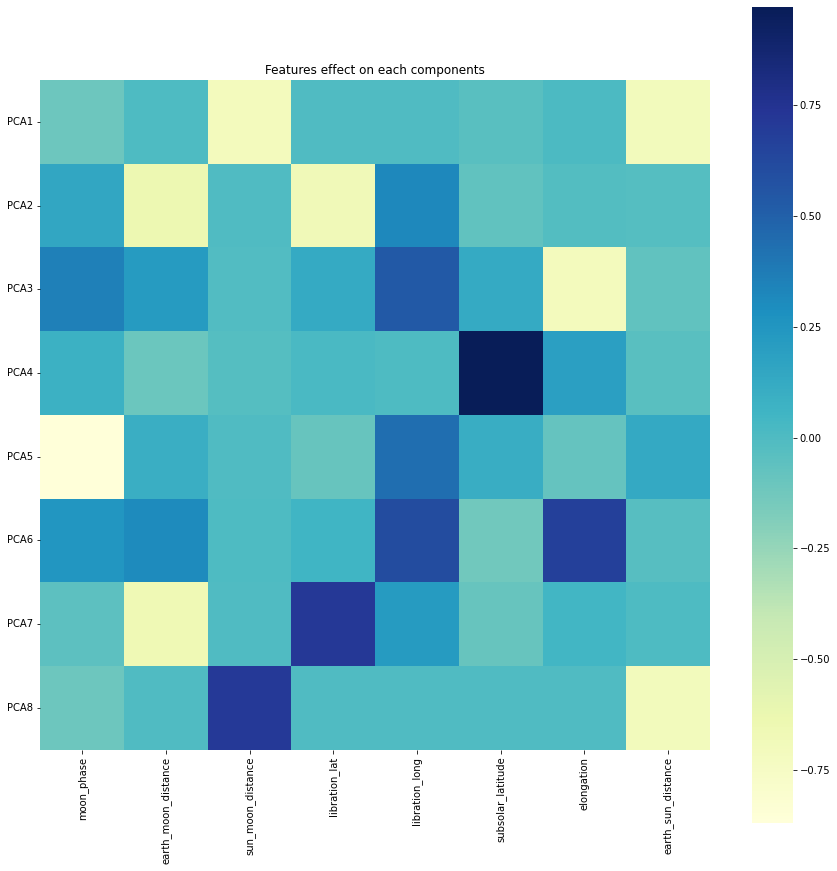

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca.n_components_+1)],
                 xticklabels=list(df_features.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('Features effect on each components')

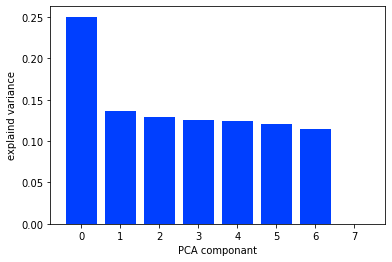

In [36]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.ylabel("explaind variance")
plt.xlabel("PCA componant");

- The first componant (mostly represented by the sun_moon_distance) is slightly more important than others, we could see an explained variance of 0.25 which is roughly the double of others componantes individual explained variance.
- Other componantes have the same importance: all have an explain variance of approximately 0.12.
- Then all features seem equally important with slightly more importance to the sun_moon_distance.

### Evaluation metric

Several metrics are used in the litterature for time series forcasting, each metrics has it's advantages and drowbacks or limitation. And it's really context sensitive. Since this nootebook is exploratory. I'll go with the RMSE. And I'll evaluate each timeStamp individually. Which means RMSE for prediction of day1, RMSE for predicition day2...

In [35]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

### Conclusion